In [10]:
from contextlib import closing
import io
import numpy
from copy import deepcopy

from matplotlib import pyplot
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import (
    Activation,
    Conv2D,
    Conv2DTranspose,
    Dense,
    Dropout,
    Flatten,
    Input,
    InputLayer,
    MaxPooling2D,
    Reshape,
)
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K

In [11]:
# ---------- Prepare data section ---------- #
# load mnist dataset
# x_train, y_train - training dataset and validation vector
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# make a deep copy to render data
render_x = deepcopy(x_train)

# image dimensions (assumed square)
image_size = x_train.shape[1]
input_size = image_size * image_size

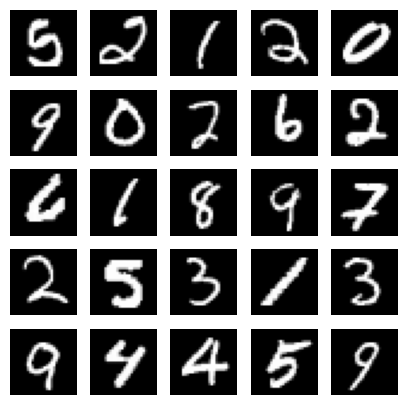

In [12]:
indexes = numpy.random.randint(0, render_x.shape[0], size=25)
images = render_x[indexes]
# plot the 25 mnist digits
pyplot.figure(figsize=(5,5))
for i in range(len(indexes)):
    pyplot.subplot(5, 5, i + 1)
    image = images[i]
    pyplot.imshow(image, cmap='gray')
    pyplot.axis('off')
pyplot.savefig('samples.png')
pyplot.show()
pyplot.close('all')

In [13]:
# network parameters
BATCH_SIZE = 64
HIDDEN_UNITS = 128
DROPOUT = 0.2
KERNEL_SIZE = 3
POOL_SIZE = 2
FILTERS = 64
EPOCHS = 3
LAYER_FILTERS = [32, 64]
INPUT_SHAPE = (image_size, image_size, 1)
LATENT_DIM = 16


def build_model(units=HIDDEN_UNITS, dropout=DROPOUT, input_size=input_size,
                kernel_size=KERNEL_SIZE, pool_size=POOL_SIZE,
                filters=FILTERS, input_shape=INPUT_SHAPE, latent_dim=LATENT_DIM,
                layer_filters=LAYER_FILTERS):

    # ENCODER
    inputs = Input(shape=input_shape, name='encoder_input')
    stack = inputs
    # stack of Conv2D(32)-Conv2D(64)
    for filters in layer_filters:
        stack = Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', strides=2, padding='same')(stack)
    shape = K.int_shape(stack)

    # LATENT
    stack = Flatten()(stack)
    latent = Dense(latent_dim, name='latent_vector')(stack)
    # print encoder
    encoder = Model(inputs, latent, name='encoder')
    # encoder.summary()
    plot_model(encoder, to_file='encoder.png', show_shapes=True)

    # DECODER
    latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
    # use the shape (7, 7, 64) that was earlier saved
    stack = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
    # from vector to suitable shape for transposed conv
    stack = Reshape((shape[1], shape[2], shape[3]))(stack)
    for filters in layer_filters[::-1]:
        stack = Conv2DTranspose(filters=filters, kernel_size=kernel_size,  activation='relu', strides=2, padding='same')(stack)

    outputs = Conv2DTranspose(filters=1, kernel_size=kernel_size, activation='sigmoid', padding='same', name='decoder_output')(stack)
    # instantiate decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')
    # decoder.summary()
    plot_model(decoder, to_file='decoder.png', show_shapes=True)

    autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
    # autoencoder.summary()
    plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
    return autoencoder


model = build_model()

# close file handler at the end of context execution
with closing(io.StringIO()) as fh:
    model.summary(print_fn=lambda x: fh.write(x + "\n"))
    summary_str = fh.getvalue()

# set up image representation
pyplot.figure(figsize=(12, 6))
pyplot.text(0, 1, summary_str, fontsize=12, family='monospace', va='top')
pyplot.axis('off')
# save as PNG
pyplot.savefig('model-summary.png', bbox_inches='tight')
pyplot.close()

In [ ]:
model.compile(loss='mse', optimizer='adam')
model.fit(x_train, x_train, validation_data=(x_test, x_test), epochs=EPOCHS, batch_size=BATCH_SIZE)
model.save('model.keras')

Epoch 1/3
938/938 [==============================] - 7s 5ms/step - loss: 0.0088 - val_loss: 0.0085
Epoch 2/3
938/938 [==============================] - 5s 5ms/step - loss: 0.0083 - val_loss: 0.0082
Epoch 3/3
938/938 [==============================] - 5s 5ms/step - loss: 0.0080 - val_loss: 0.0079


In [20]:
x_decoded = model.predict(x_test)
x_test = numpy.expand_dims(x_test, axis=-1)

313/313 [==============================] - 0s 1ms/step


In [24]:
denormalized_test_x = x_test * 255.0
denormalized_test_x = denormalized_test_x.squeeze(-1)  # (8, 28, 28, 1)
print(f"x_test shape: {denormalized_test_x[:8].shape}")
print(f"x_decoded shape: {x_decoded[:8].shape}")

normalized_array = x_decoded[:8] / numpy.max(x_decoded[:8])
normalized_array = (normalized_array * 255).astype(numpy.uint8)

x_test shape: (8, 28, 28, 1)
x_decoded shape: (8, 28, 28, 1)


In [25]:
imgs = numpy.concatenate([denormalized_test_x[:8], normalized_array])
imgs = imgs.reshape((4, 4, image_size, image_size))
imgs = numpy.vstack([numpy.hstack(i) for i in imgs])

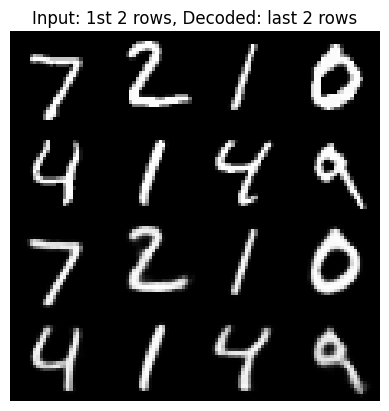

In [26]:
pyplot.figure()
pyplot.axis('off')
pyplot.title('Input: 1st 2 rows, Decoded: last 2 rows')
pyplot.imshow(imgs, interpolation='none', cmap='gray')
pyplot.savefig('input_and_decoded.png')
pyplot.show()